## Importing libraries

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.metrics import *
warnings.filterwarnings('ignore')
%matplotlib inline

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms



#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GeForce GTX 1050


## 1.1-1.2

In [2]:
# Fixed variables
epochs = 200               #maximum epochs of training
input_dm1 = 28             #Length of image
input_dm2 = 28             #Breadth of image
output_dm = 10             #Output dimension
early_stopping_rounds = 10  #Epochs after which training should stop if there is no increase in performance

In [3]:
#initializing transformer to convert values to tensor and normalize image matrices
trans = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])

#Loading datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

#Reading number of samples in each set
n_train = len(mnist_train)
n_test = len(mnist_test)



In [4]:
class Linear_Network(nn.Module):
    def __init__(self,input_dm1,input_dm2,dropout=0):
        super(Linear_Network,self).__init__()
        self.input_layer = nn.Linear(input_dm1*input_dm2, 1024)
        self.hidden_layer_1 = nn.Linear(1024, 1024)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.hidden_layer_4 = nn.Linear(1024, 1024)
        self.hidden_layer_5 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 10)
        self.dd = nn.Dropout(dropout)
#         print("Neural network defined for device: "+str(device))
#         print("Input image shape: ["+str(input_dm1)+","+str(input_dm2)+"]")
        
        
    def forward(self, x):
        
        x = self.input_layer(x)
        x = F.relu(x)
        #x = self.dd(x)
        
        #5 hidden layers
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_4(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_5(x)
        x = F.relu(x)
        #x = self.dd(x)
        
     
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        
        return x



#Uniform initialization      
def weights_init_uniform_rule(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model..
  if classname.find('Linear') != -1:
      # get the number of the inputs
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

#Function for training neural network with early stopping functionality if validation score doesn't improve
def train_neural_network(model,train_dataset,val_dataset,epochs,early_stopping_rounds,batch_size,
                         learning_rate,verbose,criterion,eval_func,input_dm1,input_dm2,device,tol,saved_model):

  
  
  
  #Dictionary where all the important outputs will be kept
  result_dict = dict()
  #Reading number of samples in each set
  n_train = len(train_dataset)
  n_val = len(val_dataset)

  # Data loader, using custom user provided batch size
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=batch_size, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                             batch_size=n_val, 
                                             shuffle=True)
  
  
  
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  
  # Train the model
  epoch=1
  stop=0
  best_performance = 0
  rounds = 0
  stop = False
  train_loss_history = []
  val_loss_history = []



  if((saved_model != None)):
    if(saved_model in os.listdir()):
      print("Pre-trained model found, to train from scratch set 'saved_model' to None")
      model.load_state_dict(torch.load("saved_model.pt"))
      early_stopping_rounds = 1
  

  
  #Training while loop 
  
  while ((epoch <= epochs)&(stop==False)):
    train_loss_arr = []
    for images, labels in train_loader:  
      # Move tensors to GPU/CPU
      images_reshaped = images.reshape(-1,input_dm1*input_dm2).to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images_reshaped)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_arr.append(loss.item())
    train_loss = torch.mean(torch.tensor(train_loss_arr))
    train_loss_history.append(train_loss)



    with torch.no_grad():
      val_images,val_labels = next(iter(val_loader))
      val_images_reshaped = val_images.reshape(-1, input_dm1*input_dm2).to(device)
      val_output = model.forward(val_images_reshaped)
      val_labels_pred = val_output.argmax(1).cpu().numpy()
      performance = round(eval_func(val_labels.numpy(),val_labels_pred),tol)
      val_loss  = criterion(val_output.to(device),val_labels.to(device)).item()
      val_loss_history.append(val_loss)


    #Check if we have an increase in performance
    if(performance > best_performance):
      rounds = 0
      best_performance = performance
      best_prediction = val_labels_pred
      best_state_dict = model.state_dict()
      result_dict["train_loader"] = train_loader
      result_dict["val_images"] = val_images
      result_dict["val_labels"] = val_labels
      result_dict["best_model"] = model
      result_dict["val_labels_pred"] = best_prediction
      result_dict["best_performance"] = best_performance
      torch.save(model, 'best_mnist_model.pt')
    else:
      rounds += 1
      if(rounds >= early_stopping_rounds):
        stop = True


    #Print statement, every 5 epochs or if it is the last epoch
    if(((epoch%5==0)|(stop==True))&(verbose==True)):
      print("EPOCH:"+str(epoch))
      if(stop==True):
        print("Training to be concluded after this epoch") 
      print("Average training loss per sample  = "+str(train_loss))
      print('Performance of the network in current epoch = '+str(round(performance,2)))
      print('Best performance of the network yet  = '+str(round(best_performance,2)))


    epoch += 1
    #While loop ends
  
  print("BEST SCORE IS:"+str(round(best_performance,2)))
  # summarize history for loss
  plt.plot(train_loss_history)
  plt.plot(val_loss_history)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
  
  return(result_dict)

In [5]:

from sklearn.metrics import accuracy_score

#Defining hyper parameters 
batch_size = 7000
dropout = 0.2
learning_rate = 0.001

#Defining model object and applying initialization
my_model = Linear_Network(input_dm1=input_dm1,input_dm2=input_dm2,dropout=dropout).to(device)


Pre-trained model found, to train from scratch set 'saved_model' to None
EPOCH:3
Training to be concluded after this epoch
Average training loss per sample  = tensor(1.4744)
Performance of the network in current epoch = 0.98
Best performance of the network yet  = 0.98
BEST SCORE IS:0.98


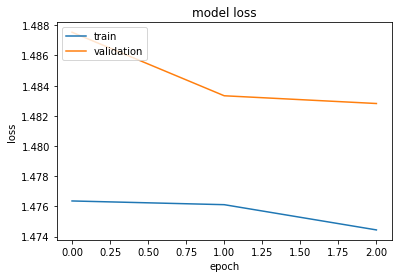

In [6]:
#Carrying out trainingz
result_dict = train_neural_network(model=my_model,
               train_dataset=mnist_train,
               val_dataset=mnist_test,
               epochs=epochs,
               early_stopping_rounds=early_stopping_rounds,
               batch_size=batch_size,
               learning_rate=learning_rate,
               verbose=True,
               eval_func=accuracy_score,
               input_dm1=input_dm1,
               input_dm2=input_dm2,
               criterion=nn.CrossEntropyLoss(),
               saved_model = None,
               tol=3,
               device=device)

train_loader = result_dict["train_loader"] 
val_images = result_dict["val_images"] 
val_labels = result_dict["val_labels"]
best_model = result_dict["best_model"] 
val_labels_pred = result_dict["val_labels_pred"] 

## 1.3-1.5

In [7]:
d_values = [10,20,50,100,200,1024]
val_images_reshaped = val_images.reshape(-1, input_dm1*input_dm2).to(device)

In [8]:
# Run SVD on W and return compressed W taking the first D eignevalues
def compress(W,D):
    (U, s, V) = torch.svd(W)
    W_d = torch.mm(torch.mm(U[:,0:D],torch.diag(s)[0:D,0:D]),V[:,0:D].T)
    assert(W.shape==W_d.shape)
    return(W_d)

In [9]:
results = pd.DataFrame()
for D in d_values:
    new_model = Linear_Network(input_dm1=input_dm1,input_dm2=input_dm2,dropout=dropout).to(device)
    
    #Making sure that apart from the weights we are modifying, all other parameters have the same value
    new_model.load_state_dict(my_model.state_dict())
    
    w = new_model.input_layer.weight.data
    new_model.input_layer.weight.data = compress(w,min(w.shape[0],w.shape[0],D))
    new_model.hidden_layer_1.weight.data = compress(new_model.hidden_layer_1.weight.data,D)
    new_model.hidden_layer_2.weight.data = compress(new_model.hidden_layer_2.weight.data,D)
    new_model.hidden_layer_3.weight.data = compress(new_model.hidden_layer_3.weight.data,D)
    new_model.hidden_layer_4.weight.data = compress(new_model.hidden_layer_4.weight.data,D)
    new_model.hidden_layer_5.weight.data = compress(new_model.hidden_layer_5.weight.data,D)
    
    
    val_labels_pred = new_model.forward(val_images_reshaped).argmax(1).cpu().numpy()
    test_accuracy = accuracy_score(val_labels.numpy(),val_labels_pred)
    results = results.append({"D":D,"test_accuracy":round(test_accuracy,3)},ignore_index=True)
results

,D,test_accuracy
0,10.0,0.795
1,20.0,0.960
2,50.0,0.978
3,100.0,0.978
4,200.0,0.978
5,1024.0,0.978


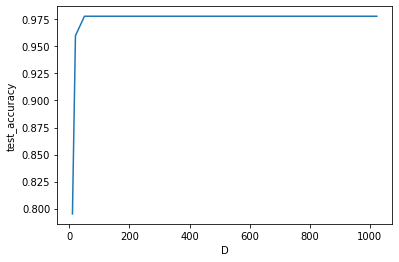

In [10]:
plt.figure()
sns.lineplot(x="D",y="test_accuracy",data=results)

## 1.6

x1 and x2 represent activations of two consecutive linear layers in a NN,
x2 = f(W * x1 + b) where W,b and f are the weight, bias and activation function respectively
If we are to replace W with a lower dimensional U and V respectively where weights of both are learned simultaneously, we will essential replace one layer with two layers  so that xm is the intermediary activation. 

Now, we have - 

*   x2 = f2(V * x_m + b2)
*   x_m = f1(U * x1 + b1)

The only modification is that f1 is identity function and b2 will be 0 and constant

In [11]:
def compress_U(W,D):
    (U, s, V) = torch.svd(W)
    U_D = U[:,0:D]
    U_D.required_grad = True
    return(U_D)

def compress_V_T(W,D):
    (U, s, V) = torch.svd(W)
    V_D = V[:,0:D].T
    V_D.required_grad = True
    return(V_D)

In [12]:
class Custom_Linear_Network(nn.Module):
    def __init__(self,input_dm1,input_dm2,D,original_model,dropout=0):
        super(Custom_Linear_Network,self).__init__()
        
        #instead of self.input_layer = nn.Linear(784,1024)
        self.v_inp = nn.Linear(input_dm1*input_dm2, D,bias=False)
        self.u_inp = nn.Linear(D,1024)
        #initializing U and V based on SVD
        self.v_inp.weight.data = compress_V_T(original_model.input_layer.weight.data,D)
        self.u_inp.weight.data = compress_U(original_model.input_layer.weight.data,D)
        
        
        
        
        
        self.v1 = nn.Linear(1024,D,bias=False)  
        self.u1 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v1.weight.data = compress_V_T(original_model.hidden_layer_1.weight.data,D)
        self.u1.weight.data = compress_U(original_model.hidden_layer_1.weight.data,D)
        
        
        self.v2 = nn.Linear(1024,D,bias=False)  
        self.u2 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v2.weight.data = compress_V_T(original_model.hidden_layer_2.weight.data,D)
        self.u2.weight.data = compress_U(original_model.hidden_layer_2.weight.data,D)
        
        self.v3 = nn.Linear(1024,D,bias=False)  
        self.u3 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v3.weight.data = compress_V_T(original_model.hidden_layer_3.weight.data,D)
        self.u3.weight.data = compress_U(original_model.hidden_layer_3.weight.data,D)
        
        
        self.v4 = nn.Linear(1024,D,bias=False)  
        self.u4 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v4.weight.data = compress_V_T(original_model.hidden_layer_4.weight.data,D)
        self.u4.weight.data = compress_U(original_model.hidden_layer_4.weight.data,D)
        
        self.v5 = nn.Linear(1024,D,bias=False)  
        self.u5 = nn.Linear(D, 1024)
        #initializing U and V based on SVD
        self.v5.weight.data = compress_V_T(original_model.hidden_layer_5.weight.data,D)
        self.u5.weight.data = compress_U(original_model.hidden_layer_5.weight.data,D)
        
        self.output_layer = nn.Linear(1024, 10)
        self.dd = nn.Dropout(dropout)

        
    def forward(self, x):
        
        x = self.v_inp(x)
        x = self.u_inp(x)
        x = F.relu(x)
        x = self.dd(x)
        
        #5 hidden layers
        x = self.v1(x)
        x = self.u1(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v2(x)
        x = self.u2(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v3(x)
        x = self.u3(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v4(x)
        x = self.u4(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.v5(x)
        x = self.u5(x)
        x = F.relu(x)
        x = self.dd(x)
        
        
        
     
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        
        return x

In [13]:
compressed_model = Custom_Linear_Network(input_dm1 = 28,
                           input_dm2 = 28,
                           D = 20,
                           original_model = my_model,
                           dropout = 0.2).to(device)


EPOCH:5
Average training loss per sample  = tensor(1.6606)
Performance of the network in current epoch = 0.84
Best performance of the network yet  = 0.84
EPOCH:10
Average training loss per sample  = tensor(1.5111)
Performance of the network in current epoch = 0.96
Best performance of the network yet  = 0.96
EPOCH:15
Average training loss per sample  = tensor(1.4912)
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.97
EPOCH:20
Average training loss per sample  = tensor(1.4861)
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.97
EPOCH:25
Average training loss per sample  = tensor(1.4813)
Performance of the network in current epoch = 0.98
Best performance of the network yet  = 0.98
EPOCH:30
Average training loss per sample  = tensor(1.4798)
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.98
EPOCH:35
Training to be concluded after this epoch
Average training los

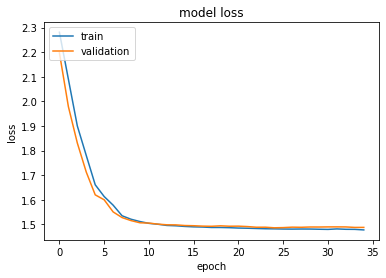

In [14]:
result_dict_compressed = train_neural_network(model=compressed_model,
               train_dataset=mnist_train,
               val_dataset=mnist_test,
               epochs=epochs,
               early_stopping_rounds=early_stopping_rounds,
               batch_size=batch_size,
               learning_rate=learning_rate,
               verbose=True,
               eval_func=accuracy_score,
               input_dm1=input_dm1,
               input_dm2=input_dm2,
               criterion=nn.CrossEntropyLoss(),
               tol=3,
               saved_model=None,
               device=device)

In [15]:
#Comparison of forward pass time of both the networks
import time
t1 = time.time()
p1 = my_model.forward(val_images_reshaped)
t2 = time.time()
print("For original network, forward pass time per sample = "+str((t2-t1)/val_images_reshaped.shape[0]))
t3 = time.time()
p1 = compressed_model.forward(val_images_reshaped)
t4 = time.time()
print("For compressed network, forward pass time per sample = "+str((t4-t3)/val_images_reshaped.shape[0]))

For original network, forward pass time per sample = 3.140449523925781e-07
For compressed network, forward pass time per sample = 8.415889739990234e-06
